# Business understanding

##### The objective of undertaking this project is building a credit score band predicting model that can be used in credit providing businesses. With the knowledge of potential credit score band of a customer we can determine if they will be able to repay their credit hence being able to decide on not give credit to those customers in a low credit score band. While taking the project we would want to answer the following questions :

### a) Given attributes, in which credit score band does the customer belong?

##### b) Which credit score band has more EMI (Equated Monthly Installment) for all month(Jan to Aug)?

##### c) Which age group shows to have good credit score and what's their outstanding debt range?

##### d) Given credit history age, what's the EMI in each credit score band?

##### e) There are many questions to ask, a lot of them are on the article


# Data Understanding(EDA)

In [88]:
#importing all necessary libraries to be used
import numpy as np
import seaborn as sns
from scipy.stats import skew
import re
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
pd.set_option('float_format', '{:f}'.format)


#### Sourcing data

In [2]:
#reading data from the csv - The data is from KAGGLE
credit_score_data = pd.read_csv("credit_score_train.csv")

In [3]:
credit_score_data_copy = credit_score_data.copy()

In [4]:
#The data has 100K rows and 28 columns
credit_score_data.shape

(100000, 28)

In [5]:
#checking data data-types
credit_score_data.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

In [6]:
credit_score_data.Month.unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

In [7]:
month_to_number = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
}
credit_score_data['Month_Num'] = credit_score_data['Month'].map(month_to_number)

In [8]:
#A function that extracts age number from age column
def convert_credit_age_tonum(list_) :
    delimiter =' '
    elements = list_.Credit_History_Age.split(delimiter)
    return elements[0]

In [9]:
#converting all data to in the dataframe to strings
credit_score_data = credit_score_data.astype(str)

In [10]:
#converting Credit_History_Age to numerical values
credit_score_data['Credit_History_Age'] = credit_score_data.apply(convert_credit_age_tonum,axis=1) 

In [11]:
#A function that shows the percentage of numerical values in a column
def num_perc(list_) :
    num_values_perc = pd.DataFrame()
    for col in list_.columns :
        numeric_mask = pd.to_numeric(list_[col], errors='coerce').notnull()
        percentage_numeric = (numeric_mask.sum() / len(credit_score_data)) * 100
        obj = {'Col':col,'num_col_perc':percentage_numeric}
        num_values_perc = num_values_perc.append(obj, ignore_index=True)
    return num_values_perc

In [12]:
#Using the above function to create a dataframe that shows a column and the precentage of numerical values in it.
num_values_perc = num_perc(credit_score_data)

In [13]:
num_values_perc

,Col,num_col_perc
0,ID,0.000000
1,Customer_ID,0.000000
2,Month,0.000000
3,Name,0.000000
4,Age,95.061000
5,SSN,0.000000
6,Occupation,0.000000
7,Annual_Income,93.020000
8,Monthly_Inhand_Salary,84.998000
9,Num_Bank_Accounts,100.000000


In [14]:
#showing all numerical columns
num_values_perc[num_values_perc.num_col_perc>0]

,Col,num_col_perc
4,Age,95.061000
7,Annual_Income,93.020000
8,Monthly_Inhand_Salary,84.998000
9,Num_Bank_Accounts,100.000000
10,Num_Credit_Card,100.000000
11,Interest_Rate,100.000000
12,Num_of_Loan,95.215000
14,Delay_from_due_date,100.000000
15,Num_of_Delayed_Payment,90.254000
16,Changed_Credit_Limit,97.909000


In [15]:
sgs = num_values_perc[num_values_perc.num_col_perc==0]

In [16]:
list(num_values_perc[num_values_perc.num_col_perc==0].Col)

['ID',
 'Customer_ID',
 'Month',
 'Name',
 'SSN',
 'Occupation',
 'Type_of_Loan',
 'Credit_Mix',
 'Payment_of_Min_Amount',
 'Payment_Behaviour',
 'Credit_Score']

In [17]:
#Creating a list of numerical columns
num_values_perc = num_values_perc[num_values_perc.num_col_perc>0]

In [18]:
#Printing numerical columns
for col_ in num_values_perc.Col :
    print(col_)

Age
Annual_Income
Monthly_Inhand_Salary
Num_Bank_Accounts
Num_Credit_Card
Interest_Rate
Num_of_Loan
Delay_from_due_date
Num_of_Delayed_Payment
Changed_Credit_Limit
Num_Credit_Inquiries
Outstanding_Debt
Credit_Utilization_Ratio
Credit_History_Age
Total_EMI_per_month
Amount_invested_monthly
Monthly_Balance
Month_Num


In [19]:
#A function that removes non-numeric values in a numerical column, used for data cleaning
def remove_non_numeric(input_string):
    if len(input_string) == 0 :
        return np.NAN
    else :
        no_alpha_punct_except_dot_dash = re.sub(r'[^0-9.-]', '', input_string)
        result = ''.join(char for char in no_alpha_punct_except_dot_dash if 31 < ord(char) < 127)
        return result

In [20]:
#Applying the above function, removing the string values in numeric columns
for col_ in num_values_perc.Col :
    print('removing non numeric values...',col_)
    credit_score_data[col_] = credit_score_data[col_].apply(remove_non_numeric)
    credit_score_data[col_] = pd.to_numeric(credit_score_data[col_], errors='coerce').astype(float)
    print('Done!')

removing non numeric values... Age
Done!
removing non numeric values... Annual_Income
Done!
removing non numeric values... Monthly_Inhand_Salary
Done!
removing non numeric values... Num_Bank_Accounts
Done!
removing non numeric values... Num_Credit_Card
Done!
removing non numeric values... Interest_Rate
Done!
removing non numeric values... Num_of_Loan
Done!
removing non numeric values... Delay_from_due_date
Done!
removing non numeric values... Num_of_Delayed_Payment
Done!
removing non numeric values... Changed_Credit_Limit
Done!
removing non numeric values... Num_Credit_Inquiries
Done!
removing non numeric values... Outstanding_Debt
Done!
removing non numeric values... Credit_Utilization_Ratio
Done!
removing non numeric values... Credit_History_Age
Done!
removing non numeric values... Total_EMI_per_month
Done!
removing non numeric values... Amount_invested_monthly
Done!
removing non numeric values... Monthly_Balance
Done!
removing non numeric values... Month_Num
Done!


In [21]:
#Checking the statistical attributes if numerical data
credit_score_data[num_values_perc.Col].describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Month_Num
count,100000.000000,100000.000000,84998.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,92998.000000,97909.000000,98035.000000,100000.000000,100000.000000,90970.000000,100000.000000,95521.000000,98800.000000,100000.000000
mean,110.649700,176415.701298,4194.170850,17.091280,22.474430,72.466040,3.009960,21.068780,30.923342,10.389025,27.754251,1426.220376,32.285173,17.966516,1403.118217,637.412998,-30364372469635625254912.000000,4.500000
std,686.244717,1429618.051414,3183.686167,117.404834,129.057410,466.422621,62.647879,14.860104,226.031892,6.789496,193.177339,1155.129026,5.116875,8.319862,8306.041270,2043.319327,3181295008384109317718016.000000,2.291299
min,-500.000000,7005.930000,303.645417,-1.000000,0.000000,1.000000,-100.000000,-5.000000,-3.000000,-6.490000,0.000000,0.230000,20.000000,0.000000,0.000000,0.000000,-333333333333333314856026112.000000,1.000000
25%,24.000000,19457.500000,1625.568229,3.000000,4.000000,8.000000,1.000000,10.000000,9.000000,5.320000,3.000000,566.072500,28.052567,12.000000,30.306660,74.534002,270.092209,2.750000
50%,33.000000,37578.610000,3093.745000,6.000000,5.000000,13.000000,3.000000,18.000000,14.000000,9.400000,6.000000,1166.155000,32.305784,18.000000,69.249473,135.925682,336.719190,4.500000
75%,42.000000,72790.920000,5957.448333,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,14.870000,9.000000,1945.962500,36.496663,25.000000,161.224249,265.731733,470.220186,6.250000
max,8698.000000,24198062.000000,15204.633333,1798.000000,1499.000000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,33.000000,82331.000000,10000.000000,1602.040519,8.000000


In [22]:
# Creating dataframes for visualizations
emi_months = credit_score_data[['Total_EMI_per_month','Month','Month_Num']].groupby(['Month']).mean().sort_values('Month_Num').reset_index()
emi_age = credit_score_data[['Total_EMI_per_month','Age']].groupby(['Age']).mean().sort_values('Age').reset_index()
del_payments_month = credit_score_data[['Num_of_Delayed_Payment','Month','Month_Num']].groupby(['Month']).sum().sort_values('Month_Num').reset_index()
del_payments_age = credit_score_data[['Num_of_Delayed_Payment','Age','Month_Num']].groupby(['Age']).sum().sort_values('Age').reset_index()
sal_pay_beh = credit_score_data[['Monthly_Inhand_Salary','Payment_Behaviour']].groupby(['Payment_Behaviour']).sum().sort_values('Payment_Behaviour').reset_index()
score_class_age = credit_score_data[['Age','Credit_Score']].groupby(['Credit_Score']).mean().sort_values('Credit_Score').reset_index()
amount_invested_age = credit_score_data[['Age','Amount_invested_monthly']].groupby(['Age']).mean().sort_values('Age').reset_index()
amount_invested_creditscore = credit_score_data[['Credit_Score','Amount_invested_monthly']].groupby(['Credit_Score']).mean().sort_values('Credit_Score').reset_index()

In [23]:
#Checking behaviour payments distribution
credit_score_data.Payment_Behaviour.value_counts()

Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: Payment_Behaviour, dtype: int64

In [24]:
#Checking credit score band payments distribution
credit_score_data.Credit_Score.value_counts()

Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64

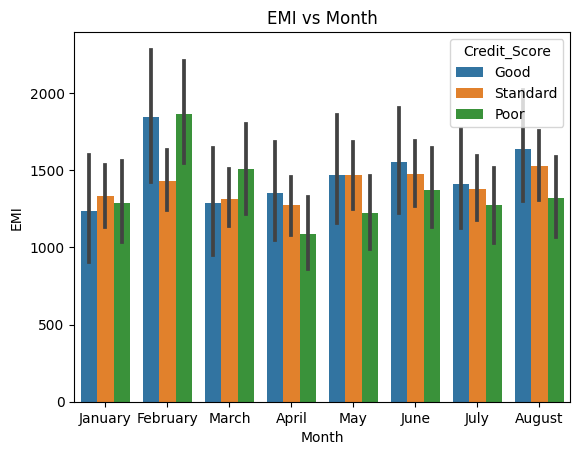

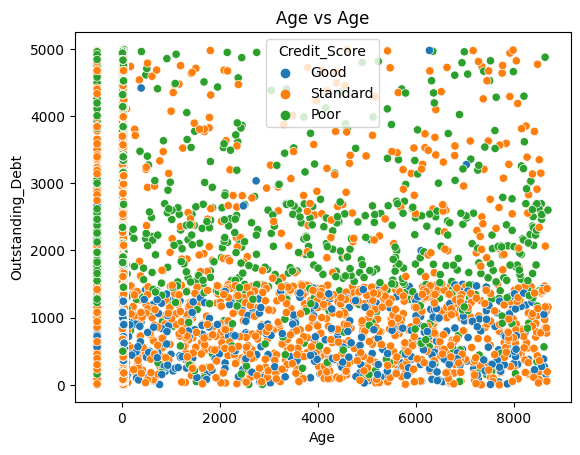

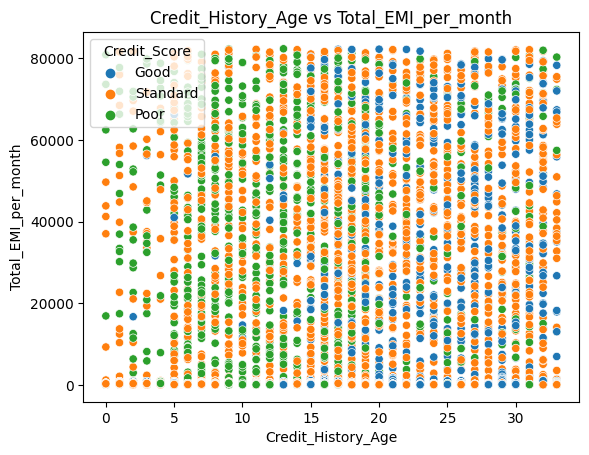

In [25]:
#Using graphs to visuals insights extracted
sns.barplot(x='Month', y='Total_EMI_per_month', hue='Credit_Score', data=credit_score_data)
plt.xlabel('Month')
plt.ylabel('EMI')
plt.title('EMI vs Month')
plt.show()

sns.scatterplot(x='Age', y='Outstanding_Debt', hue='Credit_Score', data=credit_score_data)
plt.xlabel('Age')
plt.ylabel('Outstanding_Debt')
plt.title('Age vs Age')
plt.show()

sns.scatterplot(x='Credit_History_Age', y='Total_EMI_per_month', hue='Credit_Score', data=credit_score_data)
plt.xlabel('Credit_History_Age')
plt.ylabel('Total_EMI_per_month')
plt.title('Credit_History_Age vs Total_EMI_per_month')
plt.show()


# Preparing Data

In [26]:
credit_score_data = credit_score_data.dropna(subset=['ID'])

In [27]:
#credit_score_data = credit_score_data[credit_score_data.ID == 'nan']

In [28]:
#Trimming age to real-world age, during EDA we realized that our mean age was 110 years, which meant the were outliers
credit_score_data = credit_score_data[(credit_score_data.Age>=0) & (credit_score_data.Age <= 100) & (credit_score_data.Num_Bank_Accounts >= 0) &  (credit_score_data.Num_Bank_Accounts >= 0) & (credit_score_data.Num_of_Delayed_Payment>=0) & (credit_score_data.Monthly_Balance>=0) & (credit_score_data.Num_of_Loan>=0) & (credit_score_data.Delay_from_due_date>=0) & (credit_score_data.Changed_Credit_Limit>=0)] 
print(" we now have",credit_score_data.shape[0],"rows and",credit_score_data.shape[1],"columns ")

 we now have 81643 rows and 29 columns 


In [29]:
#Function shows percentage of missing values in a dataframe form
def missing_value_percentages(df) :
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                    'percent_missing': percent_missing})
    return missing_value_df

In [30]:
#ceating a dataframe that column and missing values percentage
credit_score_data_missing = missing_value_percentages(credit_score_data)

In [31]:
credit_score_data_missing

,column_name,percent_missing
ID,ID,0.000000
Customer_ID,Customer_ID,0.000000
Month,Month,0.000000
Name,Name,0.000000
Age,Age,0.000000
SSN,SSN,0.000000
Occupation,Occupation,0.000000
Annual_Income,Annual_Income,0.000000
Monthly_Inhand_Salary,Monthly_Inhand_Salary,15.027620
Num_Bank_Accounts,Num_Bank_Accounts,0.000000


In [32]:
#We show statisctical attributes of our data, our mean age is now 33, which means our data now comforms to the real-world
credit_score_data.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Month_Num
count,81643.000000,81643.000000,69374.000000,81643.000000,81643.000000,81643.000000,81643.000000,81643.000000,81643.000000,81643.000000,80058.000000,81643.000000,81643.000000,74291.000000,81643.000000,77999.000000,81643.000000,81643.000000
mean,33.220460,173625.211835,4124.443364,17.197273,22.602023,73.075536,7.158066,21.321583,31.213588,10.647114,27.458593,1436.629490,32.311898,17.864815,1424.078430,623.949159,400.362744,4.502223
std,10.757846,1422645.291380,3145.778248,117.700771,129.333845,470.484746,60.366697,14.773136,226.000965,6.643758,191.055827,1158.582834,5.108304,8.313472,8369.210968,2032.508574,212.048969,2.293350
min,14.000000,7005.930000,303.645417,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230000,20.881250,0.000000,0.000000,0.000000,0.007760,1.000000
25%,24.000000,19249.610000,1611.910417,4.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.620000,3.000000,572.550000,28.089602,11.000000,30.305906,73.384444,269.598090,3.000000
50%,33.000000,36818.290000,3043.851667,6.000000,6.000000,14.000000,3.000000,18.000000,14.000000,9.580000,6.000000,1174.530000,32.339576,18.000000,68.427060,133.060530,335.498388,5.000000
75%,42.000000,71625.200000,5874.366667,8.000000,7.000000,20.000000,5.000000,28.000000,18.000000,15.090000,9.000000,1968.720000,36.522539,25.000000,156.531442,255.704756,467.147401,7.000000
max,100.000000,24198062.000000,15204.633333,1798.000000,1499.000000,5797.000000,1496.000000,67.000000,4397.000000,36.490000,2597.000000,4998.070000,50.000000,33.000000,82331.000000,10000.000000,1602.040519,8.000000


In [33]:
#A function that detects the skewness of the data
def skewness_detector(dataset,col):
    skewness = skew(dataset[col])
    if skewness > 0:
        return "left-skewed"
    elif skewness < 0:
        return "left-skewed"
    else:
        return "symmetrical"

In [34]:
#Using the above function
cols_distribution_df = pd.DataFrame()
for col_ in num_values_perc.Col :
    skewness = skewness_detector(credit_score_data,col_)
    obj = {'Column':col_,'Skewness':skewness}
    cols_distribution_df = cols_distribution_df.append(obj, ignore_index=True)

In [35]:
#Function that removes outliers using z-score, used for normally distributed data
def remove_outliers_zscores(data_frame,cols):
    cleaned_df = data_frame.copy()
    for column_name in cols:
        Highest_allowed = cleaned_df[column_name].mean() + 3*cleaned_df[column_name].std()
        Lowest_allowed = cleaned_df[column_name].mean() - 3*cleaned_df[column_name].std()
        cleaned_df = cleaned_df[(cleaned_df[column_name] < Highest_allowed) & (cleaned_df[column_name] > Lowest_allowed)]

    return cleaned_df

In [36]:
#Function that removes outliers IQR, used for normally left/right skewed data
def remove_outliers_iqr(data_frame,cols):
    cleaned_df = data_frame.copy()
    for column_name in cols:
        Q1 = cleaned_df[column_name].quantile(0.25)
        Q3 = cleaned_df[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cleaned_df = cleaned_df[(cleaned_df[column_name] >= lower_bound) & (cleaned_df[column_name] <= upper_bound)]
    return cleaned_df

In [37]:
#Scaling data
ids = credit_score_data['ID']
df_scaled = credit_score_data[['ID','Age',
'Annual_Income',
'Monthly_Inhand_Salary',
'Num_Bank_Accounts',
'Num_Credit_Card',
'Interest_Rate',
'Num_of_Loan',
'Delay_from_due_date',
'Num_of_Delayed_Payment',
'Changed_Credit_Limit',
'Num_Credit_Inquiries',
'Outstanding_Debt',
'Credit_Utilization_Ratio','Credit_History_Age','Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance','Month_Num']].drop(columns=['ID'])
scaler = MinMaxScaler()
scaled_data_min_max = scaler.fit_transform(df_scaled)
scaled_data_min_max = pd.DataFrame(scaled_data_min_max, columns=df_scaled.columns)
scaled_data_min_max['ID'] = ids
scaled_data_min_max = scaled_data_min_max[['ID'] + list(df_scaled.columns)]

In [38]:
scaled_data_min_max.shape

(81643, 19)

In [39]:
scaled_data_min_max['product'] = scaled_data_min_max.prod(axis=1)

In [40]:
skewness = skewness_detector(scaled_data_min_max,['product'])

In [41]:
skewness

'left-skewed'

In [42]:
scaled_df_min_max_wou = remove_outliers_iqr(scaled_data_min_max,['product'])

In [43]:
scaled_df_min_max_wou.shape

(64926, 20)

In [44]:
scaled_df_min_max_wou_copy = scaled_df_min_max_wou[["ID"]].merge(credit_score_data,on="ID")

In [45]:
scaled_df_min_max_wou_copy.shape

(53032, 29)

In [46]:
scaled_df_min_max_wou_copy[['Age',
'Annual_Income',
'Monthly_Inhand_Salary',
'Num_Bank_Accounts',
'Num_Credit_Card',
'Interest_Rate',
'Num_of_Loan',
'Delay_from_due_date',
'Num_of_Delayed_Payment',
'Changed_Credit_Limit',
'Num_Credit_Inquiries',
'Outstanding_Debt',
'Credit_Utilization_Ratio','Credit_History_Age','Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance']].describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,53032.000000,53032.000000,45164.000000,53032.000000,53032.000000,53032.000000,53032.000000,53032.000000,53032.000000,53032.000000,52047.000000,53032.000000,53032.000000,48276.000000,53032.000000,50657.000000,53032.000000
mean,33.352448,176409.607998,4101.769320,16.448295,22.450200,74.396232,7.514501,21.325615,30.152493,10.608204,27.369493,1438.713945,32.341548,17.821133,1430.258556,612.457990,399.673470
std,10.787122,1449566.585085,3147.051950,113.751591,129.222316,476.572678,63.227451,14.771544,217.416636,6.653962,189.737567,1163.486688,5.114309,8.312357,8378.402765,2008.651248,211.837708
min,14.000000,7005.930000,319.556250,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.540000,20.881250,0.000000,0.000000,0.000000,0.088628
25%,25.000000,19151.850000,1603.301667,4.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.560000,3.000000,568.770000,28.115976,11.000000,30.705226,73.073901,269.392936
50%,33.000000,36366.680000,3002.003333,6.000000,6.000000,14.000000,3.000000,18.000000,14.000000,9.530000,6.000000,1175.670000,32.371890,18.000000,68.839655,132.693873,334.795313
75%,42.000000,71522.200000,5853.558333,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,15.070000,9.000000,1967.200000,36.564923,25.000000,154.824136,254.495281,465.760657
max,100.000000,24198062.000000,15204.633333,1798.000000,1499.000000,5797.000000,1496.000000,67.000000,4397.000000,36.490000,2597.000000,4998.070000,50.000000,33.000000,82236.000000,10000.000000,1602.040519


In [47]:
df_without_outliers_missing = missing_value_percentages(scaled_df_min_max_wou_copy)

In [48]:
df_without_outliers_missing

,column_name,percent_missing
ID,ID,0.000000
Customer_ID,Customer_ID,0.000000
Month,Month,0.000000
Name,Name,0.000000
Age,Age,0.000000
SSN,SSN,0.000000
Occupation,Occupation,0.000000
Annual_Income,Annual_Income,0.000000
Monthly_Inhand_Salary,Monthly_Inhand_Salary,14.836325
Num_Bank_Accounts,Num_Bank_Accounts,0.000000


In [49]:
scaled_df_min_max_wou_copy.head(1)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Month_Num
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23.000000,821-00-0265,Scientist,19114.120000,1824.843333,3.000000,...,809.980000,26.822620,22.000000,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good,1.000000


In [50]:
df_without_outliers_copy = scaled_df_min_max_wou_copy.copy()

In [51]:
df_without_outliers_copy.Credit_Score.value_counts()

Standard    28317
Poor        15668
Good         9047
Name: Credit_Score, dtype: int64

In [52]:
df_without_outliers_copy.drop(['ID','Customer_ID','Type_of_Loan','Name','SSN'],axis=1,inplace=True)

In [53]:
nominal_df = df_without_outliers_copy.drop(num_values_perc.Col,axis=1)#.drop("Credit_Score",axis=1)

In [54]:
for col in nominal_df.columns:
    print('-------------------------',col)
    print(nominal_df[col].value_counts())

------------------------- Month
July        6715
January     6655
June        6646
May         6644
March       6611
August      6604
February    6588
April       6569
Name: Month, dtype: int64
------------------------- Occupation
_______          3711
Lawyer           3455
Architect        3392
Developer        3373
Mechanic         3364
Doctor           3325
Accountant       3315
Entrepreneur     3289
Engineer         3271
Teacher          3269
Media_Manager    3258
Scientist        3256
Journalist       3219
Writer           3214
Manager          3211
Musician         3110
Name: Occupation, dtype: int64
------------------------- Credit_Mix
Standard    19757
Good        12326
_           10654
Bad         10295
Name: Credit_Mix, dtype: int64
------------------------- Payment_of_Min_Amount
Yes    28455
No     18250
NM      6327
Name: Payment_of_Min_Amount, dtype: int64
------------------------- Payment_Behaviour
Low_spent_Small_value_payments      13359
High_spent_Medium_value_payment

In [55]:
data = df_without_outliers_copy[['Age','Annual_Income','Monthly_Inhand_Salary','Num_Bank_Accounts','Num_Credit_Card','Interest_Rate','Num_of_Loan','Delay_from_due_date','Num_of_Delayed_Payment','Changed_Credit_Limit','Num_Credit_Inquiries','Outstanding_Debt','Credit_Utilization_Ratio','Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance','Month']]

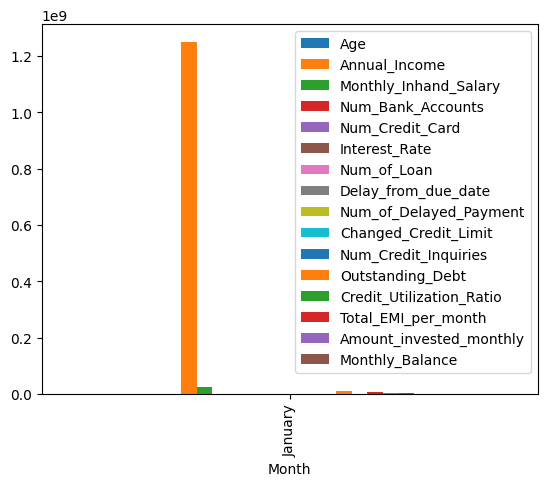

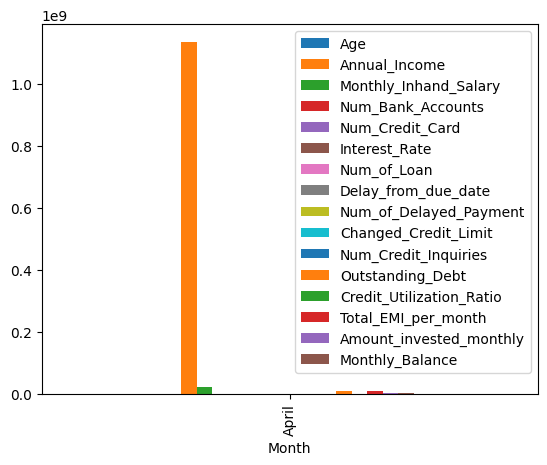

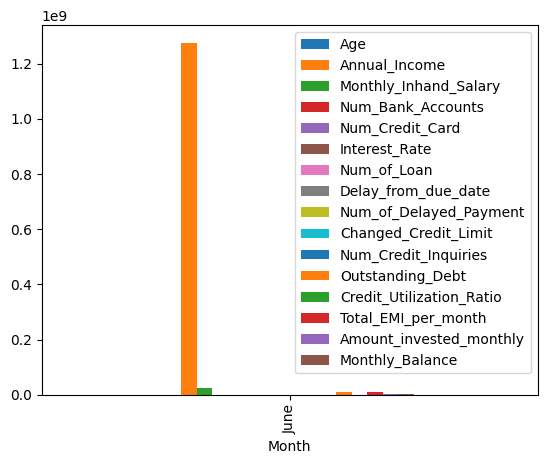

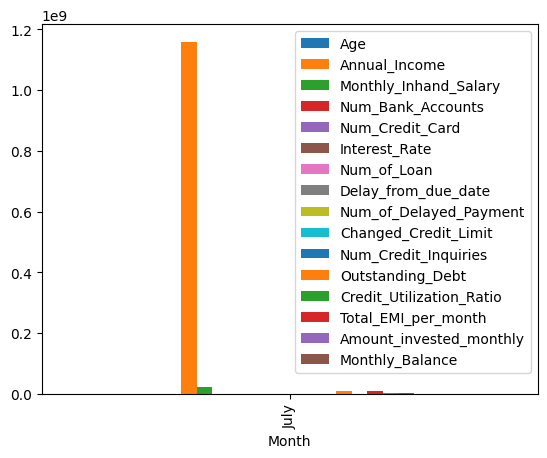

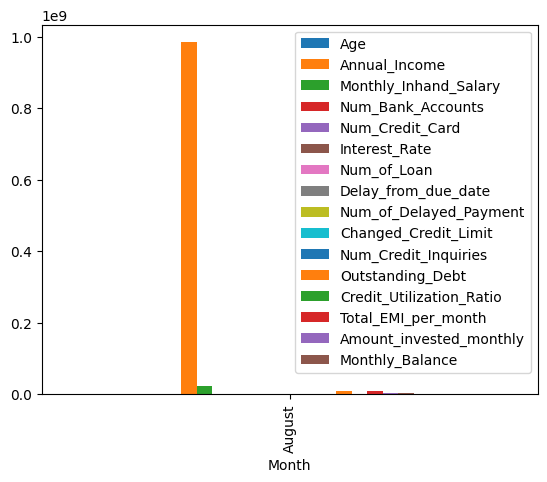

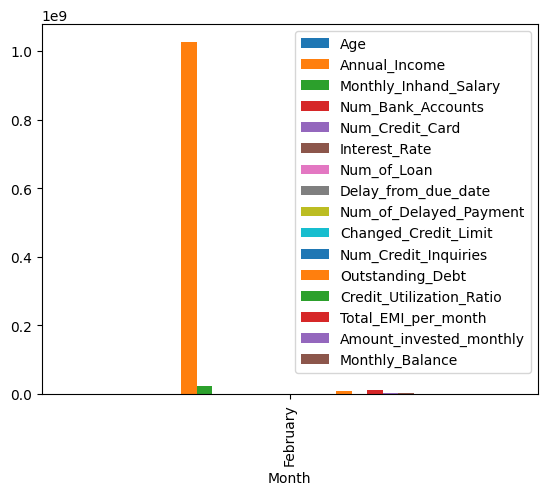

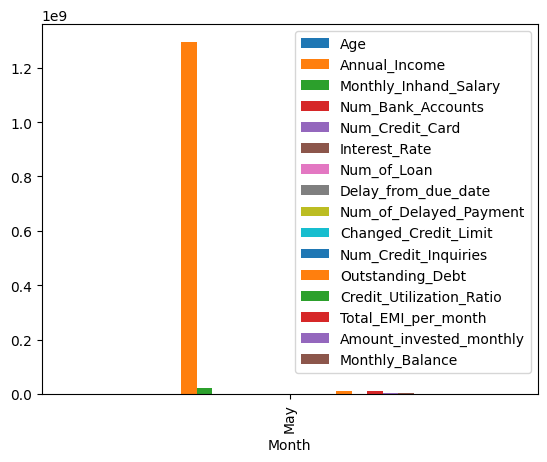

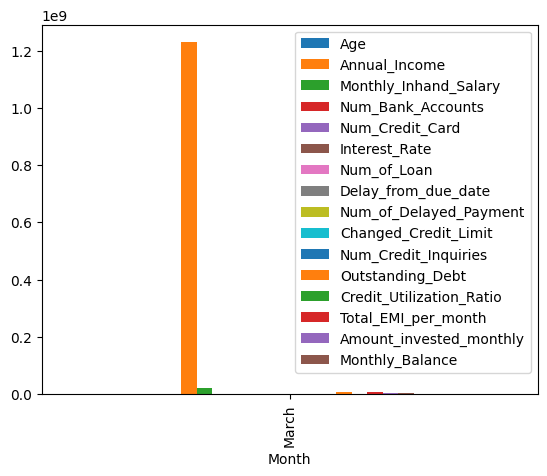

In [56]:
#Visualizing variables trends for different months
for month in df_without_outliers_copy.Month.unique():
    data = df_without_outliers_copy[df_without_outliers_copy.Month == month ]
    data[['Age','Annual_Income','Monthly_Inhand_Salary','Num_Bank_Accounts','Num_Credit_Card','Interest_Rate','Num_of_Loan','Delay_from_due_date','Num_of_Delayed_Payment','Changed_Credit_Limit','Num_Credit_Inquiries','Outstanding_Debt','Credit_Utilization_Ratio','Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance','Month']].groupby(['Month']).sum().plot(kind="bar")

In [57]:
# Creating dataframes for visualizations
emi_age = df_without_outliers_copy[['Total_EMI_per_month','Age']].groupby(['Age']).mean().sort_values('Age').reset_index()
del_payments_month = df_without_outliers_copy[['Num_of_Delayed_Payment','Month','Month_Num']].groupby(['Month']).sum().sort_values('Month_Num').reset_index()
del_payments_age = df_without_outliers_copy[['Num_of_Delayed_Payment','Age','Month_Num']].groupby(['Age']).sum().sort_values('Age').reset_index()
sal_pay_beh = df_without_outliers_copy[['Monthly_Inhand_Salary','Payment_Behaviour']].groupby(['Payment_Behaviour']).sum().sort_values('Payment_Behaviour').reset_index()
score_class_age = df_without_outliers_copy[['Age','Credit_Score']].groupby(['Credit_Score']).mean().sort_values('Credit_Score').reset_index()
amount_invested_age = df_without_outliers_copy[['Age','Amount_invested_monthly']].groupby(['Age']).mean().sort_values('Age').reset_index()
amount_invested_creditscore = df_without_outliers_copy[['Credit_Score','Amount_invested_monthly']].groupby(['Credit_Score']).mean().sort_values('Credit_Score').reset_index()

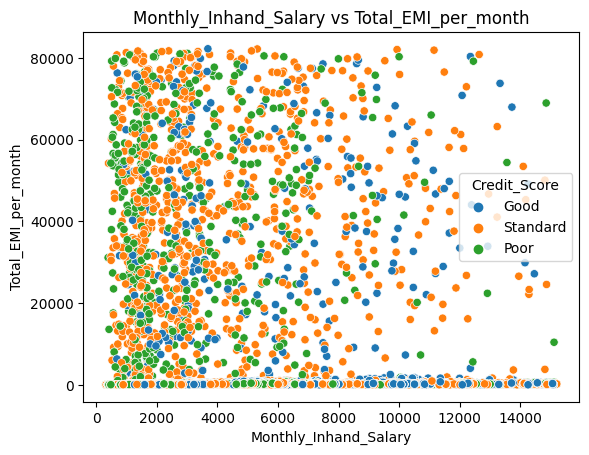

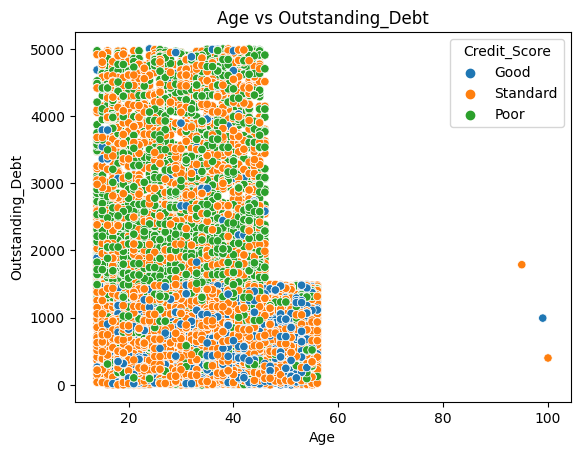

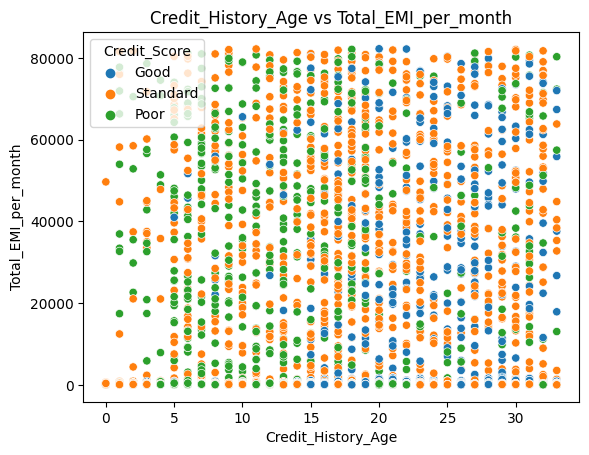

In [58]:

sns.scatterplot(x='Monthly_Inhand_Salary', y='Total_EMI_per_month', hue='Credit_Score', data=df_without_outliers_copy)
plt.xlabel('Monthly_Inhand_Salary')
plt.ylabel('Total_EMI_per_month')
plt.title('Monthly_Inhand_Salary vs Total_EMI_per_month')
plt.show()

sns.scatterplot(x='Age', y='Outstanding_Debt', hue='Credit_Score', data=df_without_outliers_copy)
plt.xlabel('Age')
plt.ylabel('Outstanding_Debt')
plt.title('Age vs Outstanding_Debt')
plt.show()

sns.scatterplot(x='Credit_History_Age', y='Total_EMI_per_month', hue='Credit_Score', data=df_without_outliers_copy)
plt.xlabel('Credit_History_Age')
plt.ylabel('Total_EMI_per_month')
plt.title('Credit_History_Age vs Total_EMI_per_month')
plt.show()

In [59]:
#Applying one hot encoding for nominal variables
ohe_df_without_outliers = pd.get_dummies(df_without_outliers_copy, columns=['Occupation',
 'Credit_Mix',
 'Payment_of_Min_Amount',
 'Payment_Behaviour']) 

In [60]:
category_mapping = {'Good': 0, 'Standard': 1, 'Poor': 2}
ohe_df_without_outliers['Credit_Score'] = ohe_df_without_outliers['Credit_Score'].map(category_mapping)

In [61]:
#Taking august data to train the model
ohe_df_without_outliers = ohe_df_without_outliers[ohe_df_without_outliers.Month == 'August']
ohe_df_without_outliers = ohe_df_without_outliers.drop(['Month','Month_Num'],axis=1)

In [62]:
ohe_df_without_outliers = ohe_df_without_outliers.fillna(0)

In [63]:
ohe_df_without_outliers_missing = missing_value_percentages(ohe_df_without_outliers)

In [64]:
ohe_df_without_outliers_missing

,column_name,percent_missing
Age,Age,0.000000
Annual_Income,Annual_Income,0.000000
Monthly_Inhand_Salary,Monthly_Inhand_Salary,0.000000
Num_Bank_Accounts,Num_Bank_Accounts,0.000000
Num_Credit_Card,Num_Credit_Card,0.000000
Interest_Rate,Interest_Rate,0.000000
Num_of_Loan,Num_of_Loan,0.000000
Delay_from_due_date,Delay_from_due_date,0.000000
Num_of_Delayed_Payment,Num_of_Delayed_Payment,0.000000
Changed_Credit_Limit,Changed_Credit_Limit,0.000000


In [65]:
print(" we now have",ohe_df_without_outliers.shape[0],"rows and",ohe_df_without_outliers.shape[1],"columns ")

 we now have 6604 rows and 48 columns 


In [66]:
#Computing correlation
corr = ohe_df_without_outliers.corr()['Credit_Score'].reset_index()

In [67]:
#showing correlations
corr.sort_values('Credit_Score',ascending=False)

,index,Credit_Score
17,Credit_Score,1.000000
7,Delay_from_due_date,0.360804
11,Outstanding_Debt,0.330917
40,Payment_of_Min_Amount_Yes,0.321422
34,Credit_Mix_Bad,0.296428
9,Changed_Credit_Limit,0.143146
47,Payment_Behaviour_Low_spent_Small_value_payments,0.129608
32,Occupation_Writer,0.053039
36,Credit_Mix_Standard,0.025656
30,Occupation_Scientist,0.016722


# Modeling and Evaluation

In [69]:
scaler = MinMaxScaler()
scaler.fit(ohe_df_without_outliers[['Delay_from_due_date','Outstanding_Debt','Payment_of_Min_Amount_Yes','Credit_Mix_Bad','Changed_Credit_Limit','Payment_Behaviour_Low_spent_Small_value_payments']])
scaled_data = scaler.transform(ohe_df_without_outliers[['Delay_from_due_date','Outstanding_Debt','Payment_of_Min_Amount_Yes','Credit_Mix_Bad','Changed_Credit_Limit','Payment_Behaviour_Low_spent_Small_value_payments']])

In [70]:
#Assigning predictors
X = scaled_data

In [72]:
#Assigning target label
y = ohe_df_without_outliers['Credit_Score']

In [96]:
#Initializing models 
models = [
    xgb.XGBClassifier(learning_rate= 0.1, max_depth= 3, n_estimators = 50),
                            SVC(C= 10, gamma= 1, kernel= 'rbf'),
                            MLPClassifier(activation='tanh', alpha= 0.001, hidden_layer_sizes= (25, 25, 25))
                            
]


In [97]:
#setting up training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,random_state=2)

----------------------------------Training XGBClassifier----------------------------------

------------------------------XGBClassifier perfomance metrics----------------------------


0.6102593223547227 - Train model score
0.5980317940953823 - Test model score 


              precision    recall  f1-score   support

           0       0.49      0.13      0.20       224
           1       0.60      0.79      0.68       711
           2       0.60      0.52      0.56       386

    accuracy                           0.60      1321
   macro avg       0.57      0.48      0.48      1321
weighted avg       0.58      0.60      0.57      1321

----------------------------------Training SVC----------------------------------

------------------------------SVC perfomance metrics----------------------------


0.58603066439523 - Train model score
0.5934897804693414 - Test model score 


              precision    recall  f1-score   support

           0       0.44      0.14      0.21       224
  

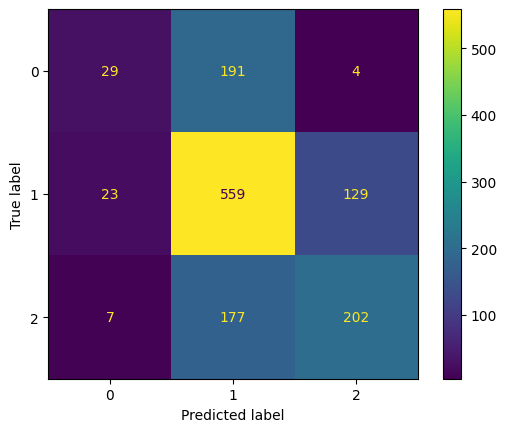

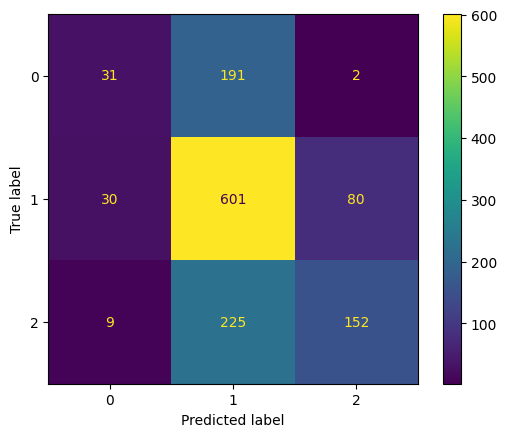

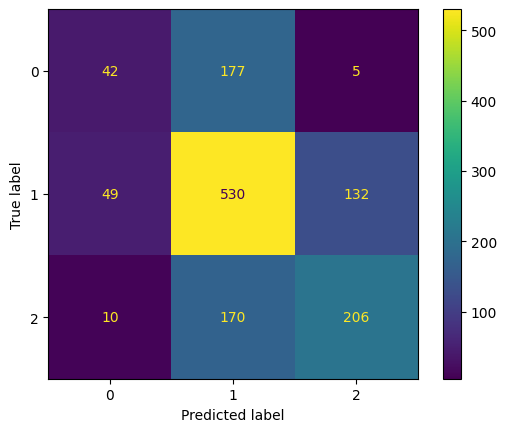

In [98]:
for model in models:
    model_name = model.__class__.__name__
    print(f"""----------------------------------Training {model_name}----------------------------------\n""")
    if model_name == "XGBClassifier" :
        model.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])
    else :
        model.fit(X_train, y_train)
    pred_test_rr= model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(y_test, pred_test_rr)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    print(f"""------------------------------{model_name} perfomance metrics----------------------------\n\n""")
    cm_display.plot()
    class_report_train = classification_report(y_test, pred_test_rr)
    print (model.score(X_train, y_train), '- Train model score')
    print(accuracy_score(y_test, pred_test_rr), '- Test model score \n\n')
    print(class_report_train)

In [89]:
models = {
    'SVM': (SVC(), {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}),
    'MLP': (MLPClassifier(), {'hidden_layer_sizes': [(100,), (50, 50), (25, 25, 25)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001, 0.01]}),
    'XGB': (XGBClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.5]})
}

# Iterate over models
for name, (model, param_grid) in models.items():
    print(f"Tuning hyperparameters for {name}")
    
    # Perform grid search cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)  # Assuming X_train and y_train are your training data
    
    # Print the best hyperparameters and corresponding mean cross-validated score
    print("Best parameters found:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)
    print()

Tuning hyperparameters for SVM
Best parameters found: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best mean cross-validated score: 0.5746724577850406

Tuning hyperparameters for MLP
Best parameters found: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (25, 25, 25)}
Best mean cross-validated score: 0.5926562813566125

Tuning hyperparameters for XGB
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best mean cross-validated score: 0.5960637596399185



# Conclusion

# 